In [1]:
import matplotlib.pyplot as plt
import pandas as pd 


In [2]:
df = pd.read_csv('../demo/data/review_results.csv')
df.head()

,title,json_file,full_input,abstract_input,human_reviews_summaries,human_reviews_summaries_lengths,gpt_3.5_full_reviews_summaries,gpt_3.5_full_reviews_summaries_lengths,gpt_3.5_full_reviews_summaries_match,gpt_3.5_full_reviews_summaries_match_lengths,...,gpt_4_full_reviews_summaries_match,gpt_4_full_reviews_summaries_match_lengths,gpt_4_abstract_reviews_summaries,gpt_4_abstract_reviews_summaries_lengths,gpt_4_abstract_reviews_summaries_match,gpt_4_abstract_reviews_summaries_match_lengths,gpt_4_abstract_reviews_one_shot_summaries,gpt_4_abstract_reviews_one_shot_summaries_lengths,gpt_4_abstract_reviews_one_shot_summaries_match,gpt_4_abstract_reviews_one_shot_summaries_match_lengths
0,A Walk with SGD: How SGD Explores Regions of D...,B1l6e3RcF7.json,[TITLE]\nA WALK WITH SGD: HOW SGD EXPLORES REG...,[TITLE]\nA WALK WITH SGD: HOW SGD EXPLORES REG...,"{\n ""1"": {\n ""summary"": ""The review ...",3,"{\n ""1"": {\n ""summary"": ""The paper l...",4,"{\n ""A2-B4"": {\n ""rationale"": ""Both ...",2,...,{},0,"{\n ""1"": {\n ""summary"": ""The paper l...",2,"{\n ""A3-B2"": {\n ""rationale"": ""Both ...",1,"{\n ""1"": {\n ""summary"": ""Lack of the...",2,"{\n ""A2-B1"": {\n ""rationale"": ""Both ...",2
1,Neural representation and generation for RNA s...,snOgiCYZgJ7.json,[TITLE]\nNEURAL REPRESENTATION AND GENERATION ...,[TITLE]\nNEURAL REPRESENTATION AND GENERATION ...,"{\n ""1"": {\n ""summary"": ""The paper l...",4,"{\n ""1"": {\n ""summary"": ""Concerns ab...",4,"{\n ""A1-B4"": {\n ""rationale"": ""Both ...",2,...,"{\n ""A1-B1"": {\n ""rationale"": ""Both ...",1,"{\n ""1"": {\n ""summary"": ""Lack of emp...",2,{},0,"{\n ""1"": {\n ""summary"": ""Complexity ...",2,{},0
2,Deep Neural Networks as Gaussian Processes,B1EA-M-0Z.json,[TITLE]\nDEEP NEURAL NETWORKS AS GAUSSIAN PROC...,[TITLE]\nDEEP NEURAL NETWORKS AS GAUSSIAN PROC...,"{\n ""1"": {\n ""summary"": ""Lack of com...",4,"{\n ""1"": {\n ""summary"": ""Computation...",4,"{\n ""A1-B4"": {\n ""rationale"": ""Both ...",1,...,"{\n ""A2-B1"": {\n ""rationale"": ""Both ...",2,"{\n ""1"": {\n ""summary"": ""The paper m...",3,"{\n ""A2-B2"": {\n ""rationale"": ""Both ...",2,"{\n ""1"": {\n ""summary"": ""Computation...",3,"{\n ""A1-B1"": {\n ""rationale"": ""Both ...",3
3,PseudoSeg: Designing Pseudo Labels for Semanti...,-TwO99rbVRu.json,[TITLE]\nPSEUDOSEG: DESIGNING PSEUDO LABELS FO...,[TITLE]\nPSEUDOSEG: DESIGNING PSEUDO LABELS FO...,"{\n ""1"": {\n ""summary"": ""Concerns ab...",3,"{\n ""1"": {\n ""summary"": ""Insufficien...",4,"{\n ""A2-B2"": {\n ""rationale"": ""Both ...",1,...,{},0,"{\n ""1"": {\n ""summary"": ""The paper l...",2,"{\n ""A2-B1"": {""rationale"": ""Review A2 quest...",1,"{\n ""1"": {\n ""summary"": ""Comparison ...",2,"{\n ""A2-B2"": {\n ""rationale"": ""Both ...",2
4,Model-Free Model Reconciliation,Byex4T2XcV.json,[TITLE]\nModel-Free Model Reconciliation\n\n[A...,[TITLE]\nModel-Free Model Reconciliation\n\n[A...,"{\n ""1"": {\n ""summary"": ""Lack of cla...",2,"{\n ""1"": {\n ""summary"": ""Assumption ...",4,"{\n ""A2-B4"": {\n ""rationale"": ""Both ...",1,...,"{\n ""A2-B2"": {\n ""rationale"": ""Both ...",3,"{\n ""1"": {\n ""summary"": ""The paper l...",3,"{\n ""A1-2-B2"": {\n ""rationale"": ""Bot...",2,"{\n ""1"": {\n ""summary"": ""Concern abo...",2,"{\n ""A2-2-B2"": {\n ""rationale"": ""Bot...",1


In [3]:
def calculate_metric_with_df(df, prefixes):
    results = {}
    
    for prefix in prefixes:

        # cols = [col for col in df.columns if col.startswith(prefix)]

        hit_count = df[f"{prefix}_summaries_match_lengths"]
        total_human_reviews = df[f"human_reviews_summaries_lengths"]
        total_gpt_reviews = df[f"{prefix}_summaries_lengths"]

        hit_rate = hit_count / total_human_reviews 
        jaccard_index = hit_count / (total_human_reviews + total_gpt_reviews - hit_count)
        sorensen_dice_coefficient = 2 * hit_count / (total_human_reviews + total_gpt_reviews)

        min_col = df[['human_reviews_summaries_lengths', f'{prefix}_summaries_lengths']].min(axis=1)
        szymkiewicz_simpson_coefficient = hit_count / min_col

        results[prefix] = {
            "hit_rate" : hit_rate.mean(), \
            "szymkiewicz_simpson_coefficient" : szymkiewicz_simpson_coefficient.mean(), \
            "jaccard_index" : jaccard_index.mean(), \
            "sorensen_dice_coefficient" : sorensen_dice_coefficient.mean()
        }
    
    return results

In [4]:
prefixes = set(["gpt_3.5_full_reviews", "gpt_3.5_abstract_reviews", "gpt_3.5_abstract_reviews_one_shot", "gpt_4_full_reviews", "gpt_4_abstract_reviews", "gpt_4_abstract_reviews_one_shot"])
results = calculate_metric_with_df(df, prefixes)
results

{'gpt_4_full_reviews': {'hit_rate': 0.2958333333333333,
  'szymkiewicz_simpson_coefficient': 0.31666666666666665,
  'jaccard_index': 0.21583333333333338,
  'sorensen_dice_coefficient': 0.27476190476190476},
 'gpt_3.5_abstract_reviews': {'hit_rate': 0.5133333333333334,
  'szymkiewicz_simpson_coefficient': 0.5916666666666667,
  'jaccard_index': 0.36083333333333334,
  'sorensen_dice_coefficient': 0.46988095238095234},
 'gpt_4_abstract_reviews_one_shot': {'hit_rate': 0.3458333333333333,
  'szymkiewicz_simpson_coefficient': 0.45,
  'jaccard_index': 0.26666666666666666,
  'sorensen_dice_coefficient': 0.3711904761904762},
 'gpt_3.5_abstract_reviews_one_shot': {'hit_rate': 0.30166666666666664,
  'szymkiewicz_simpson_coefficient': 0.45,
  'jaccard_index': 0.26166666666666666,
  'sorensen_dice_coefficient': 0.3559523809523809},
 'gpt_3.5_full_reviews': {'hit_rate': 0.5491666666666666,
  'szymkiewicz_simpson_coefficient': 0.5541666666666666,
  'jaccard_index': 0.3272619047619048,
  'sorensen_dice

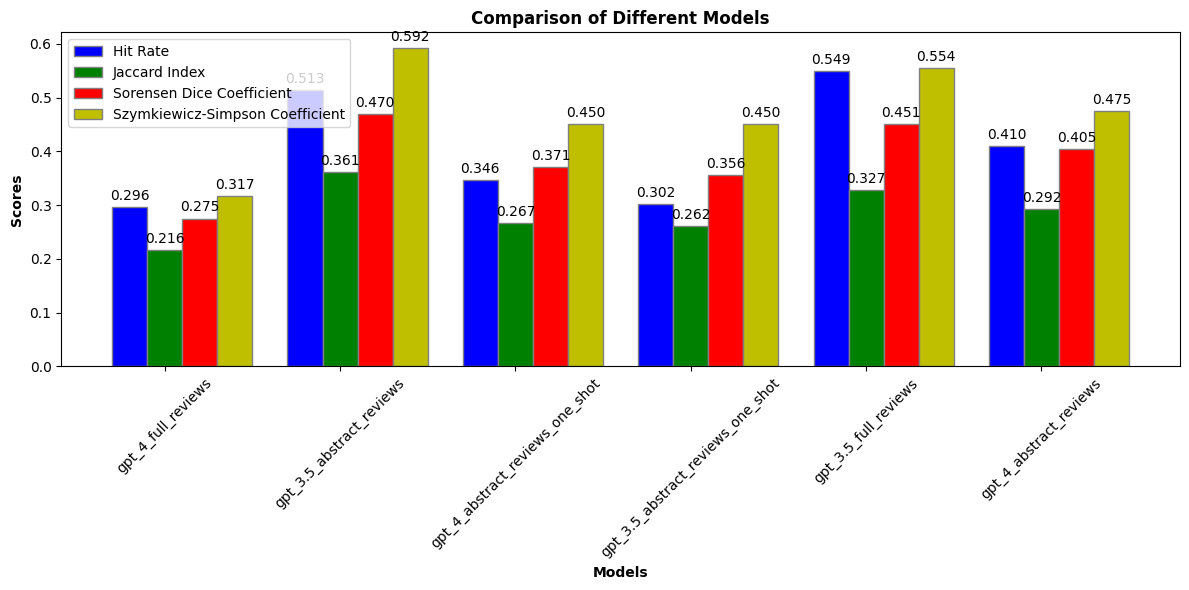

In [5]:
# Extracting data
data = results

models = list(data.keys())
hit_rates = [data[model]['hit_rate'] for model in models]
jaccard_indices = [data[model]['jaccard_index'] for model in models]
sorensen_dice_coefficients = [data[model]['sorensen_dice_coefficient'] for model in models]
szymkiewicz_simpson_coefficient = [data[model]['szymkiewicz_simpson_coefficient'] for model in models]

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2

# Positions for bars
r1 = range(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width*2 for x in r1]
r4 = [x + bar_width*3 for x in r1]

# Plotting bars
ax.bar(r1, hit_rates, color='b', width=bar_width, edgecolor='grey', label='Hit Rate')
ax.bar(r2, jaccard_indices, color='g', width=bar_width, edgecolor='grey', label='Jaccard Index')
ax.bar(r3, sorensen_dice_coefficients, color='r', width=bar_width, edgecolor='grey', label='Sorensen Dice Coefficient')
ax.bar(r4, szymkiewicz_simpson_coefficient, color='y', width=bar_width, edgecolor='grey', label='Szymkiewicz-Simpson Coefficient')

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

bars = ax.patches
add_labels(bars)

# Adding labels
ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Scores', fontweight='bold')
ax.set_title('Comparison of Different Models', fontweight='bold')
ax.set_xticks([r + bar_width for r in range(len(models))])
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# # Extracting data
# data = results

# metrics = ['hit_rate', 'szymkiewicz_simpson_coefficient', 'jaccard_index', 'sorensen_dice_coefficient']
# models = list(data.keys())
# values = {metric: [data[model][metric] for model in models] for metric in metrics}

# # Plotting
# fig, axs = plt.subplots(4, 1, figsize=(10, 30))

# for i, metric in enumerate(metrics):
#     axs[i].bar(models, values[metric], color=plt.cm.Paired(range(len(models))))
#     axs[i].set_title(metric)
#     axs[i].set_ylabel('Score')
#     axs[i].set_xticklabels(models, rotation=45, ha='right')

# plt.tight_layout()
# plt.show()